GravLensing Project code compilation

In [10]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset


from torchvision import datasets, transforms
import torchvision
import torchinfo

torch.manual_seed(42)

new Dataset class:

In [11]:
class DatasetFolder:
    def __init__(self, root_dir, transforms):
        self.root_dir=root_dir
        self.transforms=transforms
    def __len__(self):
        return len(os.listdir(self.root_dir))
    def __getitem__(self,index):
        label=os.listdir(self.root_dir)[index]
        fits_path=r''+self.root_dir+'/'+label
        file=fits.getdata(fits_path, ext=0)
        file=file.astype(float)
        file=np.transpose(file, (1,0,2))
        if self.transforms:
            file=self.transforms(file)
        if label[:4]=='lens':
            newlabel=np.float32(1.0)
        else: newlabel=np.float32(0.0)
        
        return (file, newlabel)

Initialisation of data:

['lens_1', 'lens_2', 'lens_3', 'lens_4', 'lens_5']
['nonlens_1', 'nonlens_2', 'nonlens_3', 'nonlens_4', 'nonlens_5']
train dataset: 52200
test dataset: 17400
validation dataset: 17400
1632
544
544
mean and std after normalize:
Mean of the image: [-0.90800138 -0.68529348 -0.14534957]
Std of the image: [0.16578688 0.57136049 2.72625351]


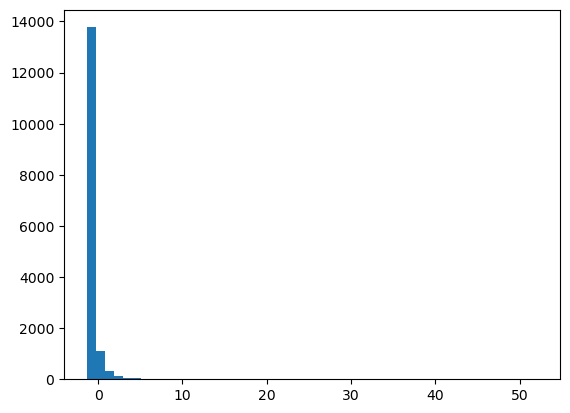

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

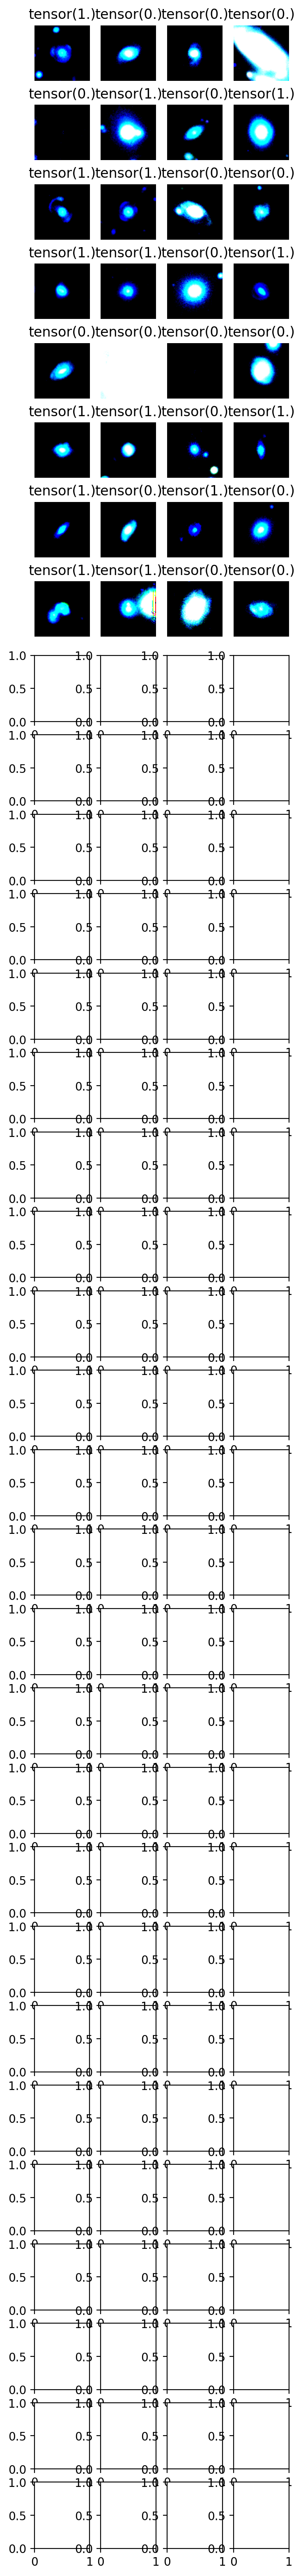

In [12]:
#class Initialisation:
    #main for excluding runtime errors in windows
#def main():

#creating relative path to data for use on different devices
filedir=r'C:/Users/sonya/gravLensing/gravlensing_sonya.francisco/tum_project/lens'
filedirnon=r'C:/Users/sonya/gravLensing/gravlensing_sonya.francisco/tum_project/nonlens'
filename1=os.listdir(filedir)
filename1non=os.listdir(filedirnon)
print(filename1) #gives the filenames lens_1 etc.
print(filename1non)

#lenses contains the subfiles of type Datasetfolder
lenses = []
nonlenses=[]

#transforms used on the images
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

for filename in filename1:
    filedir2=r''+filedir+'/'+filename
    filename2=os.listdir(filedir2)
    data=DatasetFolder(filedir2, transform)
    lenses.append(data)
for filenamenon in filename1non:
    filedir2non=r''+filedirnon+'/'+filenamenon
    filename2non=os.listdir(filedir2non)
    datanon=DatasetFolder(filedir2non, transform)
    nonlenses.append(datanon)



#concat all the lenses into one dataset
image_dataset = torch.utils.data.ConcatDataset(lenses)
image_dataset_non = torch.utils.data.ConcatDataset(nonlenses)
arr=[image_dataset, image_dataset_non]
total =torch.torch.utils.data.ConcatDataset(arr)

#splitting the images:
train_dataset, test_dataset, validation_dataset = torch.utils.data.random_split(total, [int(0.6*len(total)), int(0.2*len(total)), int(0.2*len(total))])


print('train dataset:', len(train_dataset))
print('test dataset:', len(test_dataset))
print('validation dataset:', len(validation_dataset))
#-> 1: image, 2:pixel number, 3: which of the 3 channels

#trainloader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)
#%store trainloader #magic command to store the variable so that we can use it later
classes=('lens', 'nonlens')

#np.einsum('kij->ijk',train_dataset)
print(len(trainloader)) #returns 408-> accounts for number of images in the files!!!
print(len(testloader))
print(len(validationloader))

#iterate over trainloader
#target[i][j][k][m]: i:image channel (3) OR maybe image, label? ????, j: number of batch (64), k: pixel number (up to 72), m: up to 3 (RGB)
target=next(iter(trainloader))
#target[0]-> image, target[1]-> label

#show images
fig=plt.figure()

#sanity check with image -> definetely more normalized, but completely? ~~~
#imageRGB_reshape = np.einsum('ikj->ijk',target[0][0])
img_np = np.array(target[0][0])
mean, std = np.mean(img_np, axis=(0, 1)), np.std(img_np, axis=(0, 1))
print("mean and std after normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std) 
plt.hist(img_np.ravel(), bins=50)
plt.show()

_, axs= plt.subplots(32,4, figsize=(4, 40), dpi=200) #figsize=(12, 12)
axs = axs.flatten()
for img, ax, labels in zip(target[0], axs, target[1]):
    ax.imshow(img)
    ax.set_title(labels)
    ax.axis('off')
#for j in range(128):
#    axarr[j].imshow(target[0][j])
#print('  '.join(target[1][j] for j in range(128)))

#if __name__=='__main__':
#    main()
        

Creating the model of the Network Net

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #activation=nn.ReLU()
        # 3 input image channel (I,R,B), 6 output channels, 3x3 square convolution
        #16 layers of convolution followed by a fully connected linear and an output layer
        self.net=nn.Sequential(
            nn.Conv2d(3, 6, 3),
            nn.ReLU(),
            #nn.MaxPool2d((2,2), stride=2),

            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            #nn.MaxPool2d((2,2), stride=2),
            
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(20736, 16),
            nn.ReLU(),

            nn.Linear(16, 1),
            nn.Sigmoid()
            )
        
        #self.conv12 = nn.Conv2d(6, 16, 3)

        # self.conv21 = nn.Conv2d(16, 16, 3)
        # self.conv22 = nn.Conv2d(16, 16, 3)

        # self.conv31 = nn.Conv2d(16, 16, 3)
        # self.conv32 = nn.Conv2d(16, 16, 3)

        # self.conv41 = nn.Conv2d(16, 16, 3)
        # self.conv42 = nn.Conv2d(16, 16, 3)

        # self.conv51 = nn.Conv2d(16, 16, 3)
        # self.conv52 = nn.Conv2d(16, 16, 3)

        # self.conv61 = nn.Conv2d(16, 16, 3)
        # self.conv62 = nn.Conv2d(16, 16, 3)

        # self.conv71 = nn.Conv2d(16, 16, 3)
        # self.conv72 = nn.Conv2d(16, 16, 3)

        # self.conv81 = nn.Conv2d(16, 16, 3)
        # self.conv82 = nn.Conv2d(16, 16, 3)

        # self.fc1 = nn.Linear(16 * 72 * 72, 16)  # 6*6 from image dimension
        # self.fc2 = nn.Linear(16, 1)
        # )'''
    def forward(self, x):
        # ReLu convolution over a (2, 2) window
        # '''x = F.relu(self.conv11(x), (2, 2))
        # x = F.relu(self.conv12(x), (2, 2))
        # x = F.relu(self.conv21(x), (2, 2))
        # x = F.relu(self.conv22(x), (2, 2))
        # x = F.relu(self.conv31(x), (2, 2))
        # x = F.relu(self.conv32(x), (2, 2))
        # x = F.relu(self.conv41(x), (2, 2))
        # x = F.relu(self.conv42(x), (2, 2))
        # x = F.relu(self.conv51(x), (2, 2))
        # x = F.relu(self.conv52(x), (2, 2))
        # x = F.relu(self.conv61(x), (2, 2))
        # x = F.relu(self.conv62(x), (2, 2))
        # x = F.relu(self.conv71(x), (2, 2))
        # x = F.relu(self.conv72(x), (2, 2))
        # x = F.relu(self.conv81(x), (2, 2))
        # x = F.relu(self.conv82(x), (2, 2))'''

        x=self.net(x)
        # '''x=x.flatten(start_dim=1)
        # #x = x.view(-1, self.num_flat_features(x))
        # #final fully connected linear layers with ReLu and sigmoid
        # x = F.relu(self.fc1(x))
        # x = F.sigmoid(self.fc2(x))
        # x = self.fc1(x)
        # x = self.fc2(x)'''
        return x

    #aaaahhhhAAAA
    
    # '''def num_flat_features(self, x):
    #     size = x.size()[1:]  # all dimensions except the batch dimension
    #     num_features = 1
    #     for s in size:
    #         num_features *= s
    #     return num_features'''
device = "cuda" if torch.cuda.is_available() else "cpu"
model=Net().to(device)
# torchinfo.summary(model, input_size=(128,72,72,3))
#creating the model on device
#device = "cuda" if torch.cuda.is_available() else "cpu"
#print(f"Using {device} device")
#model=Net().to(device)
# data_iterator=iter(trainloader)
# data, target=next(data_iterator)
# data=data.float()
# data_reshape=torch.permute(data, (0,3,1,2))
# #data_reshape = np.einsum('...ijk->...kij',data)
# #data_reshape1=transforms.ToTensor(data_reshape)
# dataout = model(data_reshape)
# torchinfo.summary(model, input_size=(128,3,72,72))
#print(model)

Loss Function: Cross entropy

In [21]:
loss_fn = torch.nn.BCELoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1.0, 0.0, 1.0, 0.0])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([0.1360, 0.1923, 0.8363, 0.7853])
tensor([1., 0., 1., 0.])
Total loss for this batch: 0.98152756690979


Optimizer: Stochastic gradient descent

In [22]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.0006, momentum=0.9, weight_decay=0.001)

Training loop over 100 epochs

In [23]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = np.float32(0.0)
    last_loss = np.float32(0.0)

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(trainloader):
        # Every data instance is an input + label pair
        inputs, labels = data
        #labels=labels.flatten()
        inputs=inputs.type(torch.float32)
        #print(len(inputs))
        #inputs_reshape = torch.from_numpy(np.einsum('mijk->mkij',inputs))
        inputs_reshape=torch.permute(inputs, (0,3,1,2))
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs_reshape)
        #print(type(labels))

        # Compute the loss and its gradients
        loss = loss_fn(outputs.flatten(), labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report loss for every 1000 batches
        running_loss += loss.item()
        #if i % 1000 == 999:
        if i %10 ==1:
            last_loss = running_loss / 10 #1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(trainloader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = np.float32(0.)

    return last_loss

Per-Epoch Activity: validation, save copy of model

In [18]:
# Initializing in a separate cell so we can easily add more epochs to the same run
import datetime
from torch.utils.tensorboard import SummaryWriter
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = np.float32(0.0)
    for i, vdata in enumerate(validationloader):
        vinputs, vlabels = vdata
        vinputs=vinputs.type(torch.float32)
        vinputs=torch.permute(vinputs, (0,3,1,2))
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs.flatten(), vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    #writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
        patience = 20
    else:
        patience -= 1
        
    if patience == 0:
        print("Early stopping")
        break

    epoch_number += 1

print('Finished training')
writer.flush()

EPOCH 1:
  batch 2 loss: 0.13863831758499146
  batch 12 loss: 0.6931605577468872
  batch 22 loss: 0.6930781483650208
  batch 32 loss: 0.6932308375835419
  batch 42 loss: 0.693179976940155
  batch 52 loss: 0.6929879724979401
  batch 62 loss: 0.6929215967655182
  batch 72 loss: 0.6929730236530304
  batch 82 loss: 0.6930861532688141
  batch 92 loss: 0.6926808595657349
  batch 102 loss: 0.6935995876789093
  batch 112 loss: 0.693610793352127
  batch 122 loss: 0.6931665897369385
  batch 132 loss: 0.6936156451702118
  batch 142 loss: 0.6931105613708496
  batch 152 loss: 0.6933325827121735
  batch 162 loss: 0.693233597278595
  batch 172 loss: 0.6933430075645447
  batch 182 loss: 0.6931797742843628
  batch 192 loss: 0.6931439697742462
  batch 202 loss: 0.6930546164512634
  batch 212 loss: 0.693143230676651
  batch 222 loss: 0.6933385491371155
  batch 232 loss: 0.6931142449378968
  batch 242 loss: 0.6931996643543243
  batch 252 loss: 0.6930164098739624
  batch 262 loss: 0.6928204953670501
  batc

RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 6422528 bytes.

load model:

In [ ]:
#saved_model = Net()
#saved_model.load_state_dict(torch.load(PATH))
#print(torch.cuda.is_available())

False


Testing

In [24]:
import datetime
from torch.utils.tensorboard import SummaryWriter
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
writer2 = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
tloss = 0

model.train(False)

tloss = np.float32(0.0)
for i, tdata in enumerate(testloader):
    tinputs, tlabels = tdata
    tinputs=tinputs.type(torch.float32)
    tinputs=torch.permute(tinputs, (0,3,1,2))
    with torch.no_grad():
        toutputs = model(tinputs)
    test_metric = loss_fn(toutputs.flatten(), tlabels)
    tloss += test_metric

avg_tloss = tloss / len(testloader)
#print('LOSS test {} valid {}'.format(avg_loss, avg_tloss))

    # Log the running loss averaged per batch
    # for both training and validation
#writer.add_scalars('Training vs. Validation Loss',
#                { 'Training' : avg_loss, 'Validation' : avg_tloss },
#                epoch_number + 1)
    

print('Finished testing')
print(avg_tloss)
#writer.flush()

KeyboardInterrupt: 